<a href="https://colab.research.google.com/github/ByeongKeun/Industrial-AI/blob/master/2021_1_%EC%82%B0%EC%97%85%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B0%9C%EB%A1%A0/%EA%B3%BC%EC%A0%9C/2021_0527_ResNet/2021_0527_PyTorch_ResNet_CM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # interactive mode

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip( ),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
                                 transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/camera_module_picture'

In [3]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_size = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


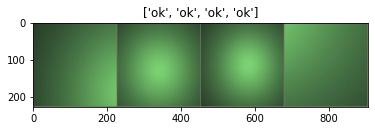

In [4]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title = [class_names[x] for x in classes])

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict( ))
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    for phase in ['train', 'test']:
      if phase == 'train':
        scheduler.step()
        model.train( )
      else:
        model.eval( )

      running_loss = 0.0
      running_correts = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad( )
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          if phase == 'train':
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_correts += torch.sum(preds == labels.data)
      epoch_loss = running_loss / dataset_size[phase]
      epoch_acc = running_correts.double() / dataset_size[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    print()
    
  time_elapsed = time.time() - since
  print('학습 완료 걸린시간: {:.0f}분 {:.0f}초'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best test Acc: {:.4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  return model

In [17]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far ==num_images:
          model.train(mode = was_training)
          return
      model.train(mode=was_training)

In [18]:
model_ft = models.resnet18(pretrained=True) #사전 학습된 ResNet18 가져오기
num_ftrs = model_ft.fc.in_features #모델에서 feature extraction 후, FC층에 입력되는 특징 수
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device) #cpu나 GPU에 model_ft를 할당
criterion = nn.CrossEntropyLoss()

#모든 파라미터를 학습
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#매 7 에포크 마다 학습률 0.1배 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.3786 Acc: 0.8889
test Loss: 0.7281 Acc: 0.8333

Epoch 1/24
----------
train Loss: 0.4205 Acc: 0.8833
test Loss: 0.4903 Acc: 0.7708

Epoch 2/24
----------
train Loss: 0.4266 Acc: 0.8833
test Loss: 0.5855 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.3924 Acc: 0.8722
test Loss: 0.5097 Acc: 0.8333

Epoch 4/24
----------
train Loss: 0.3987 Acc: 0.8889
test Loss: 0.6025 Acc: 0.8750

Epoch 5/24
----------
train Loss: 0.4386 Acc: 0.8500
test Loss: 1.2263 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.5250 Acc: 0.8889
test Loss: 0.6160 Acc: 0.8333

Epoch 7/24
----------
train Loss: 0.3589 Acc: 0.8889
test Loss: 0.4392 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.3667 Acc: 0.8889
test Loss: 0.4815 Acc: 0.8333

Epoch 9/24
----------
train Loss: 0.3560 Acc: 0.8889
test Loss: 0.4747 Acc: 0.8333

Epoch 10/24
----------
train Loss: 0.3646 Acc: 0.8889
test Loss: 0.4793 Acc: 0.8333

Epoch 11/24
----------
train Loss: 0.3377 Acc: 0.8889
test Loss: 0.4823 Acc: 0.8333

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


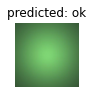

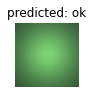

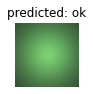

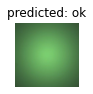

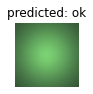

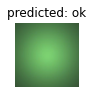

In [19]:
visualize_model(model_ft)

In [20]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False #사전 학습된 모델의 가중치를 상수로  고정. 학습시키지 않음

#새로 생성된 모듈의 파라미터는 기본적으로 requires_grad = True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

#마지막 층의 파라미터만 학습
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5238 Acc: 0.8278
test Loss: 0.5578 Acc: 0.8333

Epoch 1/24
----------
train Loss: 0.3987 Acc: 0.8778
test Loss: 0.6253 Acc: 0.8333

Epoch 2/24
----------
train Loss: 0.4077 Acc: 0.8722
test Loss: 0.4033 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.3759 Acc: 0.8889
test Loss: 0.3859 Acc: 0.8333

Epoch 4/24
----------
train Loss: 0.3828 Acc: 0.8889
test Loss: 0.4065 Acc: 0.8333

Epoch 5/24
----------
train Loss: 0.4350 Acc: 0.8722
test Loss: 0.7249 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.3797 Acc: 0.8889
test Loss: 0.3940 Acc: 0.8333

Epoch 7/24
----------
train Loss: 0.3948 Acc: 0.8778
test Loss: 0.4597 Acc: 0.8333

Epoch 8/24
----------
train Loss: 0.3328 Acc: 0.8889
test Loss: 0.4140 Acc: 0.8750

Epoch 9/24
----------
train Loss: 0.3370 Acc: 0.8889
test Loss: 0.7013 Acc: 0.8333

Epoch 10/24
----------
train Loss: 0.4218 Acc: 0.8667
test Loss: 0.3371 Acc: 0.8750

Epoch 11/24
----------
train Loss: 0.3747 Acc: 0.8889
test Loss: 0.6177 Acc: 0.8333

Epoch 12/24


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


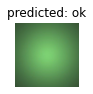

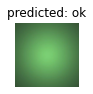

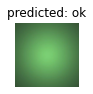

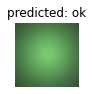

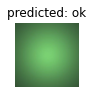

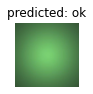

In [21]:
visualize_model(model_conv)

plt.ioff()
plt.show()